# Clustering Example

This example notebook applies *k*-means clustering to the CHI data from the [HCI Bibliography](http://hcibib.org), building on the [Week 13 Example](https://cs533.ekstrandom.net/content/week13/Week13/).

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

## Load Data

In [4]:
papers = pd.read_csv('chi-papers.csv', encoding='utf8')
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13403 entries, 0 to 13402
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13292 non-null  object 
 1   year      13370 non-null  float64
 2   title     13370 non-null  object 
 3   keywords  3504 non-null   object 
 4   abstract  12872 non-null  object 
dtypes: float64(1), object(4)
memory usage: 523.7+ KB


Let's treat empty abstracts as empty strings:

In [5]:
papers['abstract'].fillna('', inplace=True)
papers['title'].fillna('', inplace=True)

For some purposes, we want *all text*.  Let's make a field:

In [6]:
papers['all_text'] = papers['title'] + ' ' + papers['abstract']

## Raw Clustering

Let's set up a *k*-means to make 10 clusters out of our titles and abstracts.  We're going to also limit the term vectors to only the 10K most common words, to make the vectors more manageable.

In [8]:
cluster_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('cluster', KMeans(10))
])

In [9]:
cluster_pipe.fit(papers['all_text'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('cluster', KMeans(n_clusters=10))])

Now, if we want clusters for all of our papers, we use `predict`:

In [10]:
paper_clusters = cluster_pipe.predict(papers['all_text'])

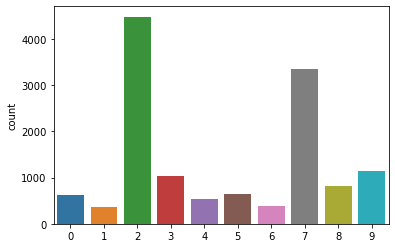

In [34]:
sns.countplot(paper_clusters)

We can, for instance, get the titles of papers in cluster 0:

In [12]:
papers.loc[paper_clusters == 0, 'title']

44       The Streamlined Cognitive Walkthrough Method, ...
58          The Social Life of Small Graphical Chat Spaces
200             Interacting with music in a social setting
254      Casablanca: Designing Social Communication Dev...
256                      Social Navigation of Food Recipes
                               ...                        
13194    Making interactions visible: tools for social ...
13216    Trust me, I'm accountable: trust and accountab...
13220                  Counting on community in cyberspace
13221              Social navigation: what is it good for?
13266    Emotional Interfaces for Interactive Aardvarks...
Name: title, Length: 631, dtype: object

This created a Boolean mask that is `True` where the cluster number is equal to 0, and selects those rows and the `'title'` column.

Don't know if these papers make any sense, but they are clusters.  We aren't doing anything to find the *most* central papers to the cluster, though.

We can get that with `transform`, which will transform papers into *cluster distance space* - columns are the distances between each paper and that cluster:

In [15]:
paper_cdist = cluster_pipe.transform(papers['all_text'])

And we can find the papers *closest to the center* of cluster 0:

In [32]:
closest = np.argsort(paper_cdist[:, 0])[-10:]
papers.iloc[closest]['title']

3082         Anthropomorphism: From Eliza to Terminator 2
5428                                            Shake it!
5374                                        Kick-up menus
2478    Indentation, Documentation and Programmer Comp...
5404                                    eLearning and fun
3189                                         Introduction
2781                             UIMSs: Threat or Menace?
3709                           Pointing without a pointer
5427                    PHOTOVOTE: Olympic judging system
3130                        Toward a More Humane Keyboard
Name: title, dtype: object

We can also look at clusters in space.  *t*-SNE is a technique for dimensionality reduction that is emphasized on visualizability.  Let's compute the *t*-SNE of our papers:

In [22]:
sne_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('sne', TSNE())
])
paper_sne = sne_pipe.fit_transform(papers['all_text'])
paper_sne

array([[  6.8206224,   0.6565056],
       [ 33.6402   , -15.340711 ],
       [  2.7017617,  13.163247 ],
       ...,
       [-37.581757 ,  -6.7183685],
       [-15.388872 , -37.62566  ],
       [  1.1543125,  -4.1664543]], dtype=float32)

Now we can plot:

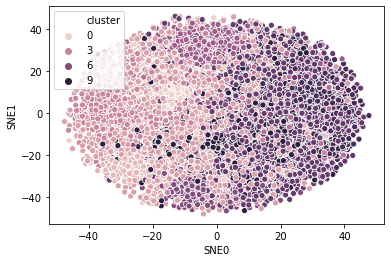

In [23]:
paper_viz = pd.DataFrame({
    'SNE0': paper_sne[:, 0],
    'SNE1': paper_sne[:, 1],
    'cluster': paper_clusters
})
sns.scatterplot('SNE0', 'SNE1', hue='cluster', data=paper_viz)

## SVD-based Clusters

Let's cluster in reduced-dimensional space:

In [36]:
svd_cluster_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(25)),
    ('cluster', KMeans(10))
])
paper_svd_clusters = svd_cluster_pipe.fit_predict(papers['all_text'])

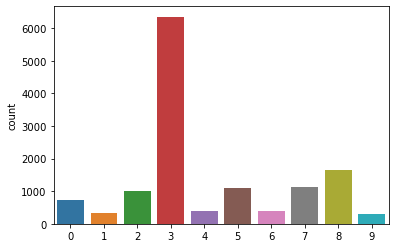

In [37]:
sns.countplot(paper_svd_clusters)

In [38]:
paper_svd_cdist = svd_cluster_pipe.transform(papers['all_text'])

Let's look at Cluster 0 in this space:

In [39]:
closest = np.argsort(paper_svd_cdist[:, 0])[-10:]
papers.iloc[closest]['title']

12018                            Visual Interaction Design
6922     Heuristic evaluation for games: usability prin...
6114     Enhancing credibility judgment of web search r...
2770     Video: Data for Studying Human-Computer Intera...
3855     A large scale study of wireless search behavio...
2860                               Search Technology, Inc.
10302    An In-Situ Study of Mobile App &amp; Mobile Se...
12010                               The Design Interaction
2508                Designing the Human-Computer Interface
3705     Older adults and web usability: is web experie...
Name: title, dtype: object

Not sure if that's better, but it shows the concept.

Let's do the color-coded SNE visualization:

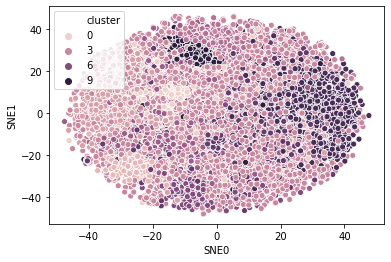

In [40]:
paper_viz = pd.DataFrame({
    'SNE0': paper_sne[:, 0],
    'SNE1': paper_sne[:, 1],
    'cluster': paper_svd_clusters
})
sns.scatterplot('SNE0', 'SNE1', hue='cluster', data=paper_viz)